# The Validation Set

This notebook explores a subset of the GTSRB (namely the speed signs) to show how the selection of the validation set can affect our expectations when using the net in unseen data.

It covers tensorflow dataset API to load local data:

- how to load local data
- prepare the dataset for training



### References

https://benchmark.ini.rub.de/gtsrb_news.html

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.youtube.com/watch?v=yH1cF7GnoIo    

https://www.datacamp.com/community/tutorials/tensorflow-tutorial    

https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/

https://surfertas.github.io/tensorflow/dl/2018/01/24/tf-data-augmentation.html


In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU, BatchNormalization

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd

BATCH_SIZE = 32
IMAGE_SIZE = 32

### Auxiliary functions for display purposes only

In [2]:
def show_batch(cols, image_batch, label_batch):

    rows = int(BATCH_SIZE / cols) 
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols
    
    
    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):
        
        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)  
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()    
    plt.show()
    
    
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['bad val set', 'good val set']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.70)
    plt.legend(loc='upper left')
    plt.show()

    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()
    

def show_confusion_matrix(model, dataset):
   
    all_labels = []
    all_preds = []

    for images , labels in dataset.take(-1):  
        numpy_labels = labels.numpy()
        numpy_images = images.numpy()
        preds = model.predict(numpy_images, verbose=0)  
        
        all_labels += [np.argmax(x) for x in numpy_labels]
        all_preds += [np.argmax(x) for x in preds]
        
    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

    df_cm = pd.DataFrame(conf_mat.numpy(), range(8), range(8))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()

    res_correct = {0:0, 1:0, 2:0, 3:0,4:0,5:0,6:0,7:0}
    res_incorrect = {0:0, 1:0, 2:0, 3:0,4:0,5:0,6:0,7:0}
    for i in range(len(all_preds)):
        if all_preds[i] == all_labels[i]:
            res_correct[all_labels[i]] += 1
        else:
            res_incorrect[all_labels[i]] += 1

    for i in range(len(res_correct)):

        print('class: ', i, ' total images: ', res_correct[i] + res_incorrect[i],' % correct: ', res_correct[i] / (res_correct[i] + res_incorrect[i]))

### Auxiliary functions to load images

In [3]:
classNames = np.array(['00000','00001', '00002', '00003', '00004', '00005', '00006', '00007'])

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

## Local Settings

set the paths to the image data and where the model and logs will be saved.

In [4]:
data_path = 'C:/Users/Utilizador/Documents/GitHub/Perfil-CG/VCPI/Classes/Class_03/Datasets'
log_and_model_path = 'C:/Users/Utilizador/Documents/GitHub/Perfil-CG/VCPI/Classes/Class_03'

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listSet = tf.data.Dataset.list_files(f'{data_path}/train_full/*/*.png')
datasetV1 = listSet.map(get_bytes_and_label, num_parallel_calls=AUTOTUNE)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Print some data and compute dataset length

In [6]:
for image, label in datasetV1.take(1):
    print('image shape: ', image.numpy().shape)
    print('label: ', label.numpy())
    
dataset_len = datasetV1.cardinality().numpy()
print('length: ', dataset_len)

image shape:  (32, 32, 3)
label:  [False False False  True False False False False]
length:  12780


## Prepare dataset

In [7]:
# Train Dataset
datasetV1 = datasetV1.cache()
datasetV1 = datasetV1.shuffle(buffer_size = dataset_len)
datasetV1 = datasetV1.batch(batch_size = BATCH_SIZE)
datasetV1 = datasetV1.prefetch(buffer_size = AUTOTUNE)

In [8]:
testset = tf.data.Dataset.list_files(f'{data_path}/test/*/*.png')
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

testset_len = testset.cardinality().numpy()
print('number of images: ', testset_len)

testset = testset.batch(batch_size = BATCH_SIZE)

testset_len = testset.cardinality().numpy()
print('number of batches: ', testset_len)


number of images:  4170
number of batches:  131


## Show first batch

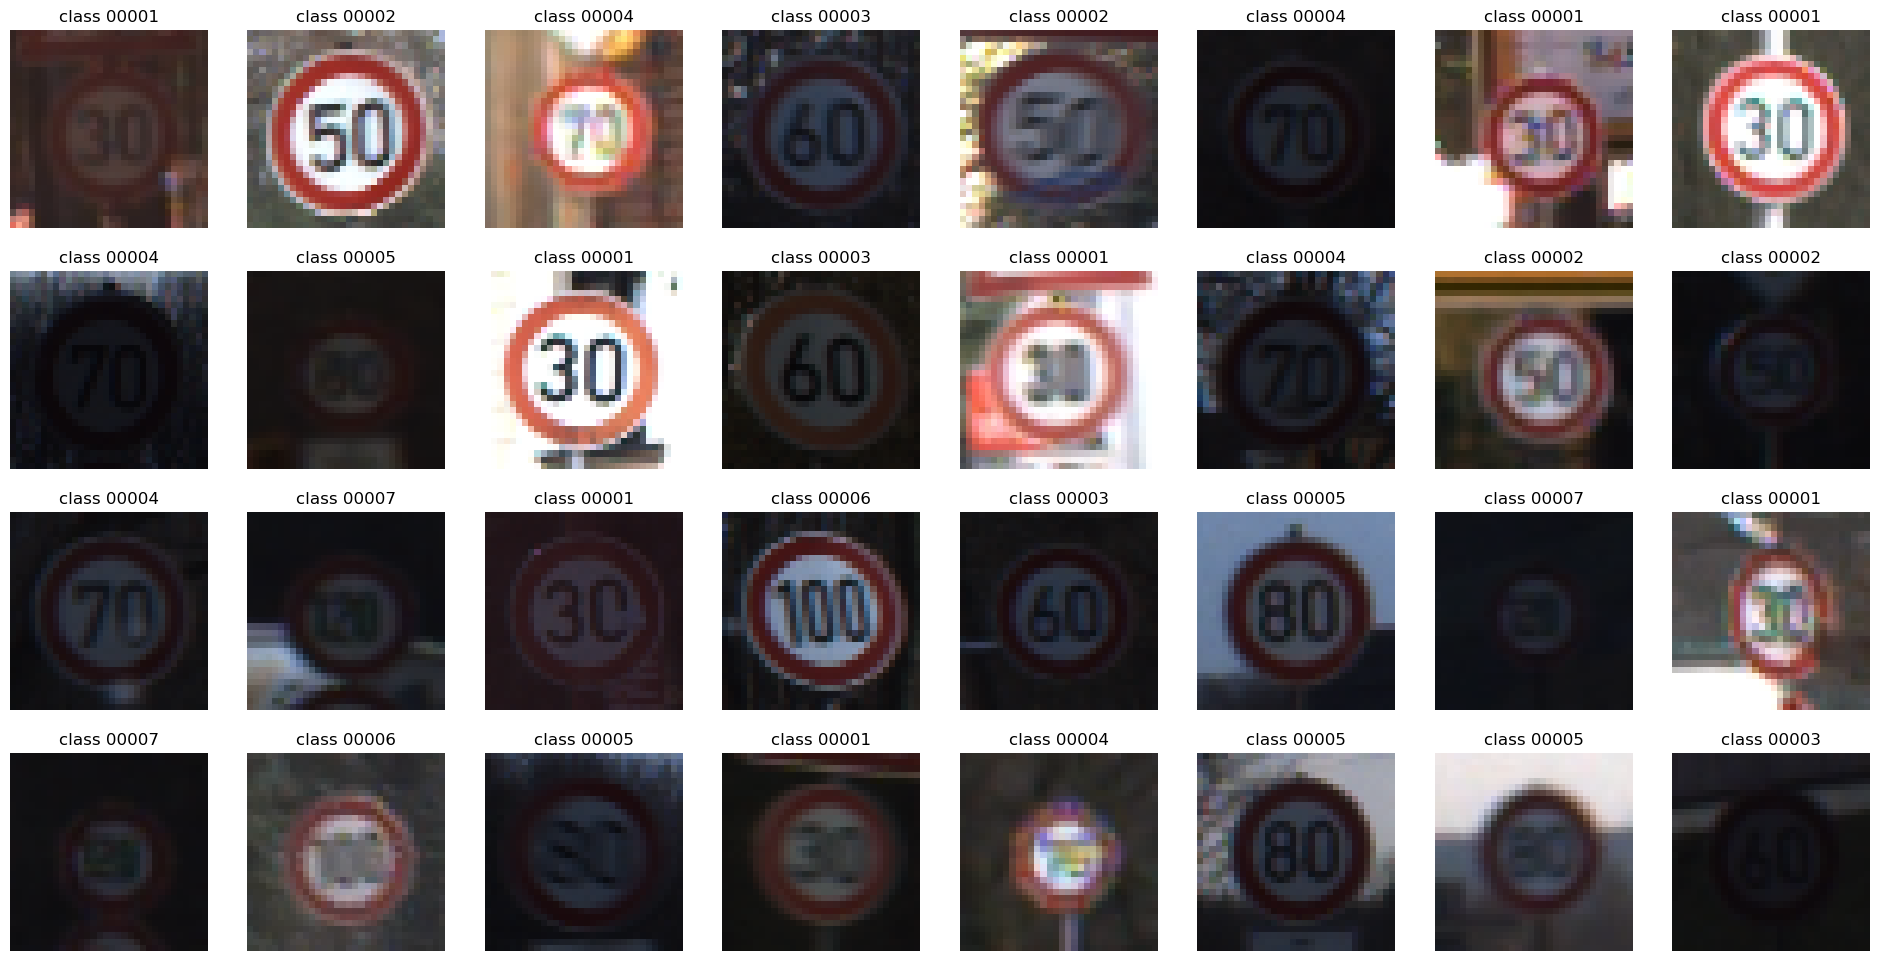

<Figure size 640x480 with 0 Axes>

In [9]:
image_batch, label_batch = next(iter(datasetV1))
show_batch(8, image_batch, label_batch.numpy())

## Define model

In [10]:
def cnn(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Input(shape=(imgSize, imgSize, channels)))
    model.add(Conv2D(64, (5,5), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, (5,5)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, (5,5)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(classCount, activation='softmax'))
    
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0

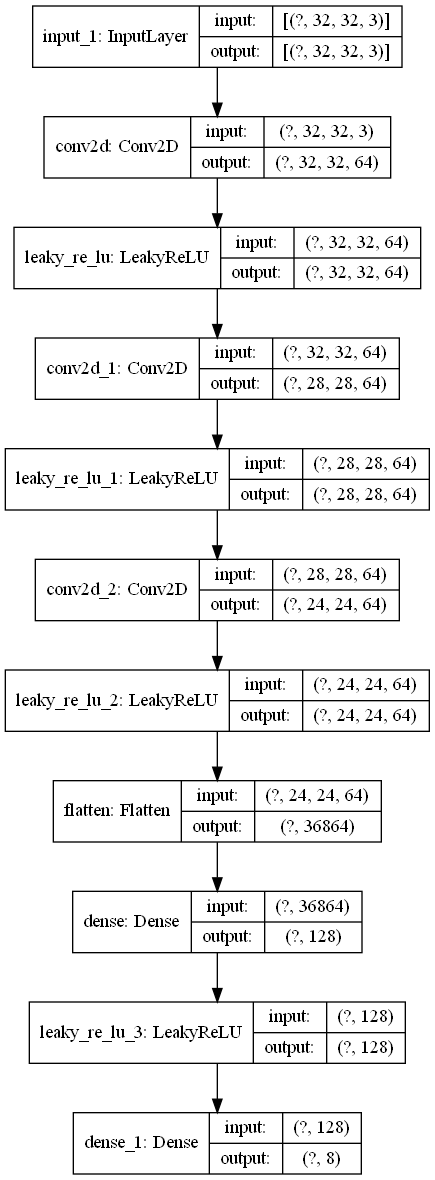

In [11]:
modelV1 = cnn(8, 32, 3)

print(modelV1.summary())
tf.keras.utils.plot_model(modelV1, show_shapes=True)

## Split dataset into training and validation sets

In [13]:
print('length: ', dataset_len)

train_size = int(0.8 * dataset_len / BATCH_SIZE)
val_size = int(0.2 * dataset_len / BATCH_SIZE)

train_dataset = datasetV1.take(train_size)
val_dataset = datasetV1.skip(train_size)

print(val_dataset.cardinality())

length:  12780
tf.Tensor(81, shape=(), dtype=int64)


## Callback definition

- saving model weights at the best epoch considering validation accuracy
 - early stopping when validation accuracy no longer drops for a number of epochs
 - record session to be available on tensorboard.
    
Go to folder where logs are locatted and call >tensorboard --logdir logs

then open a browser and go to:

http://localhost:6006/    

In [14]:
def prepareCallbacks(path):
    
    file_path = f'{log_and_model_path}/{path}/cp.ckpt'
    
    checkpointer = ModelCheckpoint(filepath=file_path, monitor='val_accuracy', verbose=1, save_weights_only=True, save_best_only=True)
    earlyStopper = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=8, verbose=1)
    tbCallBack = TensorBoard(log_dir=f'{log_and_model_path}/{path}_log', histogram_freq=0, write_graph=True, write_images=True)
    
    return file_path, [checkpointer, earlyStopper, tbCallBack]
    

## Train Model

In [15]:
file_pathV1, callbacksV1 = prepareCallbacks('valV1')

historyV1 = modelV1.fit(datasetV1, epochs=5, validation_data=val_dataset, callbacks=callbacksV1)

Epoch 1/20
  1/400 [..............................] - ETA: 0s - loss: 2.1075 - accuracy: 0.1250WARNING:tensorflow:From c:\Users\Utilizador\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
400/400 [==============================] - ETA: 0s - loss: 0.8295 - accuracy: 0.7235
Epoch 00001: val_accuracy improved from -inf to 0.92691, saving model to C:/Users/Utilizador/Documents/GitHub/Perfil-CG/VCPI/Classes/Class_03/valV1\cp.ckpt
400/400 [==============================] - 64s 161ms/step - loss: 0.8295 - accuracy: 0.7235 - val_loss: 0.2634 - val_accuracy: 0.9269
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9470
Epoch 00002: val_accuracy improved from 0.92691 to 0.97395, saving model to C:/Users/Utilizador/Documents/GitHub/Perfil-CG/VCPI/C

## Show graphs for accuracy and loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


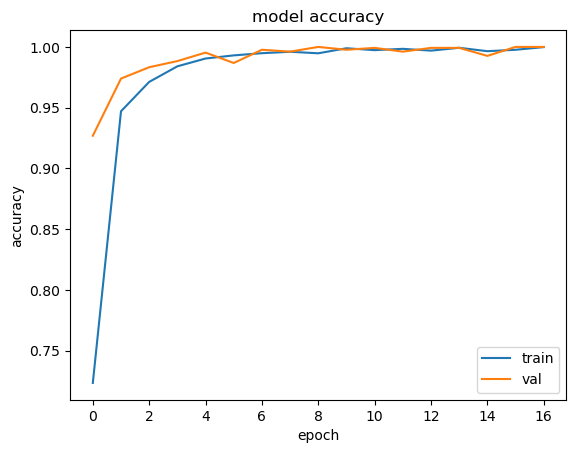

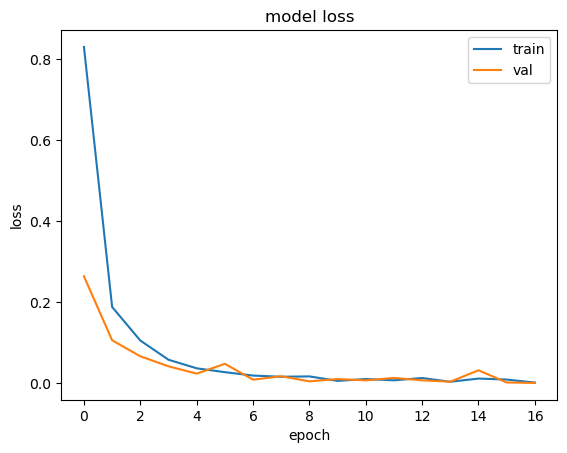

In [16]:
show_history(historyV1)

## Load weights for best epoch and evaluate model

Notice how the validation set accuracy differs from the test set accuracy. Why?

In [17]:
modelV1.load_weights(file_pathV1)
evalV1 = modelV1.evaluate(testset, verbose=2)

print('\n', evalV1, '\n')

valV1 = modelV1.evaluate(val_dataset, verbose=2)

131/131 - 6s - loss: 1.9543 - accuracy: 0.7647

 [1.9543300867080688, 0.764748215675354] 

81/81 - 2s - loss: 0.0049 - accuracy: 0.9996


# Manual partitioning of dataset

Taking into account the features of the GTSRB we explore an alternative way of partitioning the dataset into training and validation sets.

Main goal: to have validation accuracy as a better prediction of test set accuracy

In [18]:
def manualPart(path, opt):
    listset = tf.data.Dataset.list_files(path)

    data = listset.map(get_bytes_and_label, num_parallel_calls=AUTOTUNE)
    data = data.cache()
    
    if(opt==1):
        data = data.shuffle(buffer_size=10200)
        data = data.batch(batch_size=BATCH_SIZE)
        data = data.prefetch(buffer_size=AUTOTUNE)
    else:
        data = data.batch(batch_size=BATCH_SIZE)
        data = data.prefetch(buffer_size=AUTOTUNE)
    
    

In [22]:
trainsetV2 = manualPart(f'{data_path}/train/*/*.png', 1)
valset = manualPart(f'{data_path}/val/*/*.png', 0)

## Build the model and train it

In [23]:
modelV2 = cnn(8, 32, 3)

file_pathV2, callbacksV2 = prepareCallbacks('valV2')

historyV2 = modelV2.fit(trainsetV2, epochs=5, validation_data = valset, callbacks = callbacksV2)

Epoch 1/20
319/319 [==============================] - ETA: 0s - loss: 0.9689 - accuracy: 0.6674
Epoch 00001: val_accuracy improved from -inf to 0.78915, saving model to C:/Users/Utilizador/Documents/GitHub/Perfil-CG/VCPI/Classes/Class_03/valV2\cp.ckpt
319/319 [==============================] - 55s 171ms/step - loss: 0.9689 - accuracy: 0.6674 - val_loss: 0.7441 - val_accuracy: 0.7891
Epoch 2/20
319/319 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9396
Epoch 00002: val_accuracy improved from 0.78915 to 0.84380, saving model to C:/Users/Utilizador/Documents/GitHub/Perfil-CG/VCPI/Classes/Class_03/valV2\cp.ckpt
319/319 [==============================] - 51s 159ms/step - loss: 0.2067 - accuracy: 0.9396 - val_loss: 0.4774 - val_accuracy: 0.8438
Epoch 3/20
319/319 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9707
Epoch 00003: val_accuracy improved from 0.84380 to 0.87713, saving model to C:/Users/Utilizador/Documents/GitHub/Perfil-CG/VCPI/C

## Show history and accuracies with new partition

The validation accuracy is further away from the training accuracy, but at the same time it is a better predictor of the test set accuracy.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


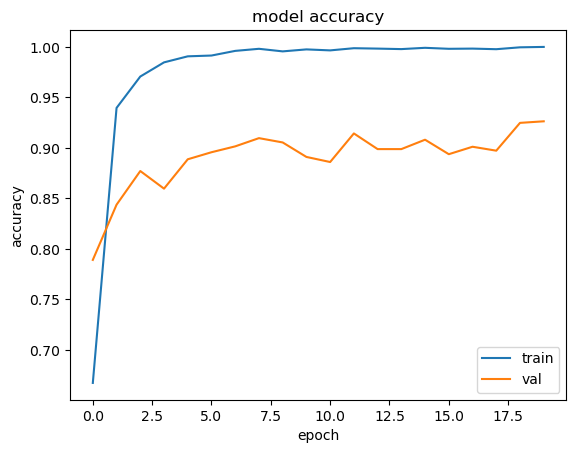

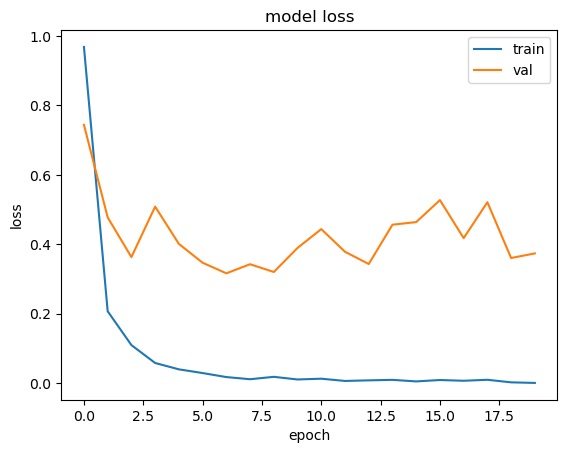

In [24]:
show_history(historyV2)

In [29]:
modelV2.load_weights(file_pathV2)

evalV2 = modelV2.evaluate(testset, verbose=2)

print('\n', evalV2, '\n')

valV2 = modelV2.evaluate(valset, verbose=2)

131/131 - 4s - loss: 2.5521 - accuracy: 0.7676

 [2.552147150039673, 0.7676259279251099] 

81/81 - 2s - loss: 0.3736 - accuracy: 0.9264


## Compare both models 

Comparison for both test and validation set accuracies

Note that it may be the case that, when comparing both models, the test set accuracy decreases in the second model. 

This is due to the fact that we now have in less data to train. 

Although the validation sets had approximatelly the same size when training both models, in the first case random images were taken from the dataset, leaving most sequences intact.

In the second situation complete sequences were taken from the training set, providing for less information during training.

 valV1:  [0.004860576242208481, 0.9996111989021301] 
 evalV1:  [1.9543300867080688, 0.764748215675354] 
 valV2:  [0.3735675811767578, 0.9263566136360168] 
 evalV2:  [2.552147150039673, 0.7676259279251099] 



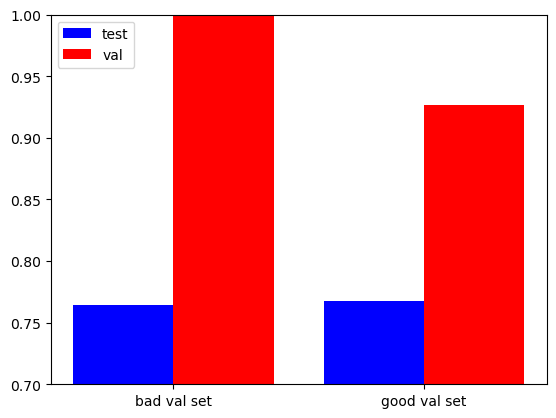

In [31]:
print(' valV1: ', valV1, '\n', 'evalV1: ', evalV1, '\n', 'valV2: ', valV2, '\n', 'evalV2: ', evalV2, '\n')

show_accuracies()

## Evaluating the model on a single image

In [32]:
import PIL
from PIL import Image

# read image
im = Image.open(f'{data_path}/test/00000/s01279.png')

# resize to (32,32)
im = im.resize((32,32))

# convert to numpy
numpy_image = np.asarray(im)

# expand to include batch info
numpy_image = np.expand_dims(numpy_image, axis = 0)

# predict
in_pred = modelV2.predict([numpy_image])
print(in_pred)

[[1. 0. 0. 0. 0. 0. 0. 0.]]


In [33]:
data, = testset.take(1)

# data[0] are the batch images; data[1] are the labels

# this shows the first 5 labels for the batch
print (data[1][:5])

#predict the first image
in_pred = modelV2.predict(np.expand_dims(data[0][0], axis = 0))
print(in_pred)

tf.Tensor(
[[ True False False False False False False False]
 [False False False False False False  True False]
 [False False  True False False False False False]
 [False False False False  True False False False]
 [False False False False  True False False False]], shape=(5, 8), dtype=bool)
[[1.0000000e+00 4.6532520e-09 1.1652576e-31 3.1326986e-31 1.3121629e-19
  3.3927257e-23 3.8403928e-35 2.2750722e-34]]


## Check the model performance

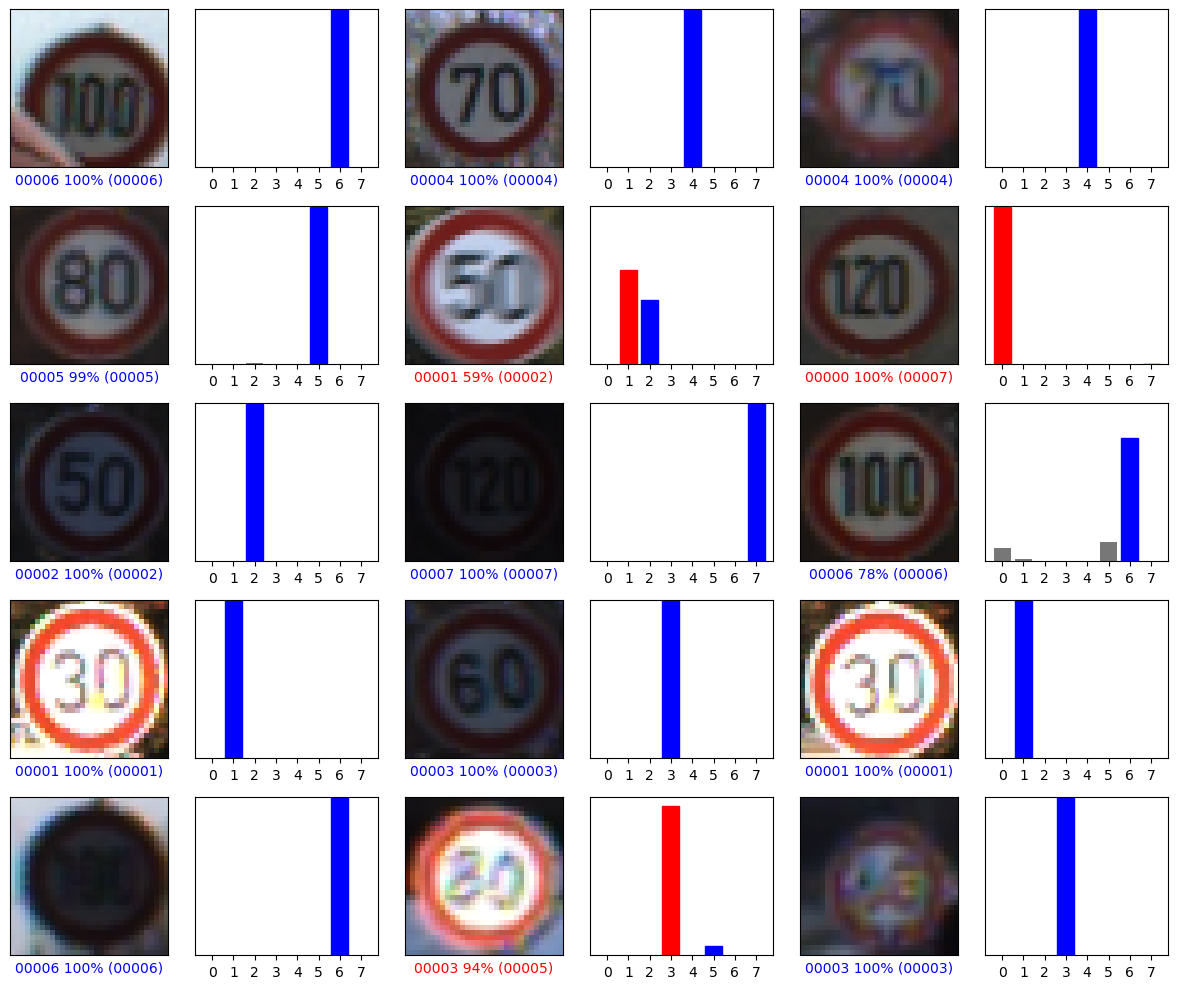

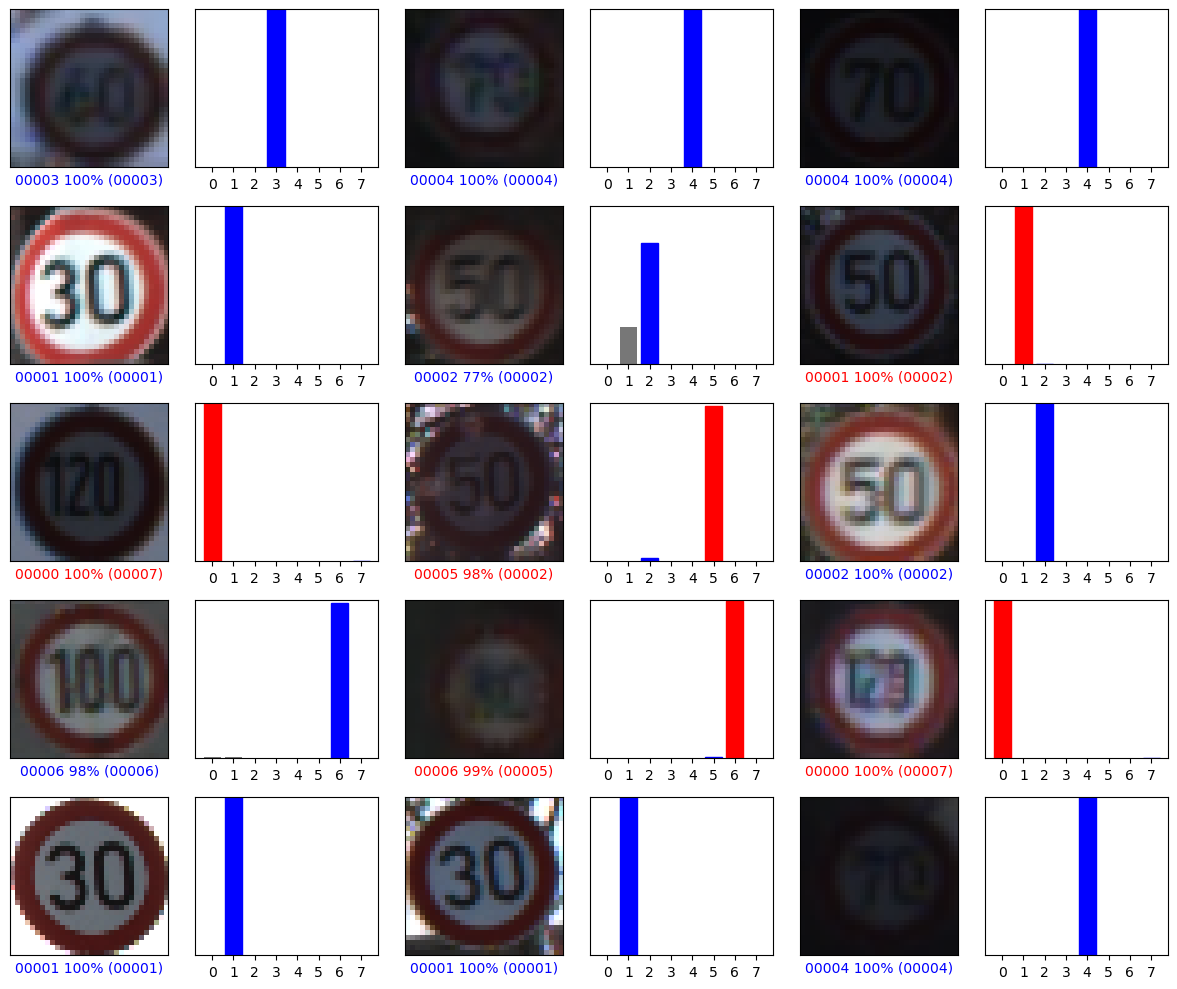

In [34]:
for images, labels in testset.take(2):  # take n batches of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
    preds = modelV2.predict(numpy_images)  
    plot_predictions(preds, numpy_labels, numpy_images, 5, 3)

## Checking misclassified images

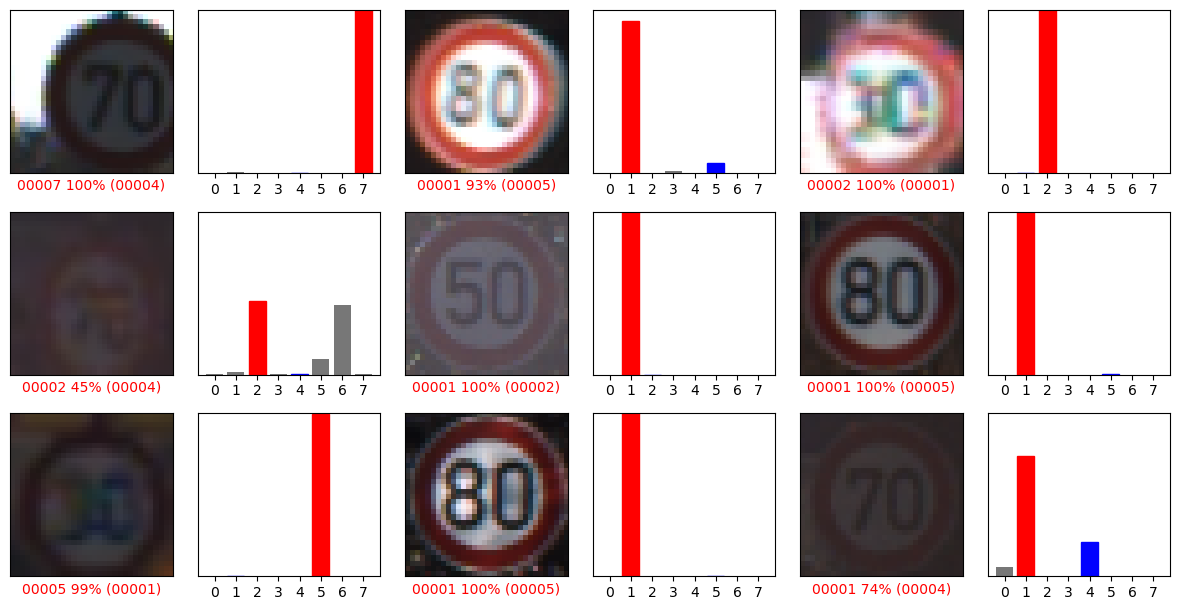

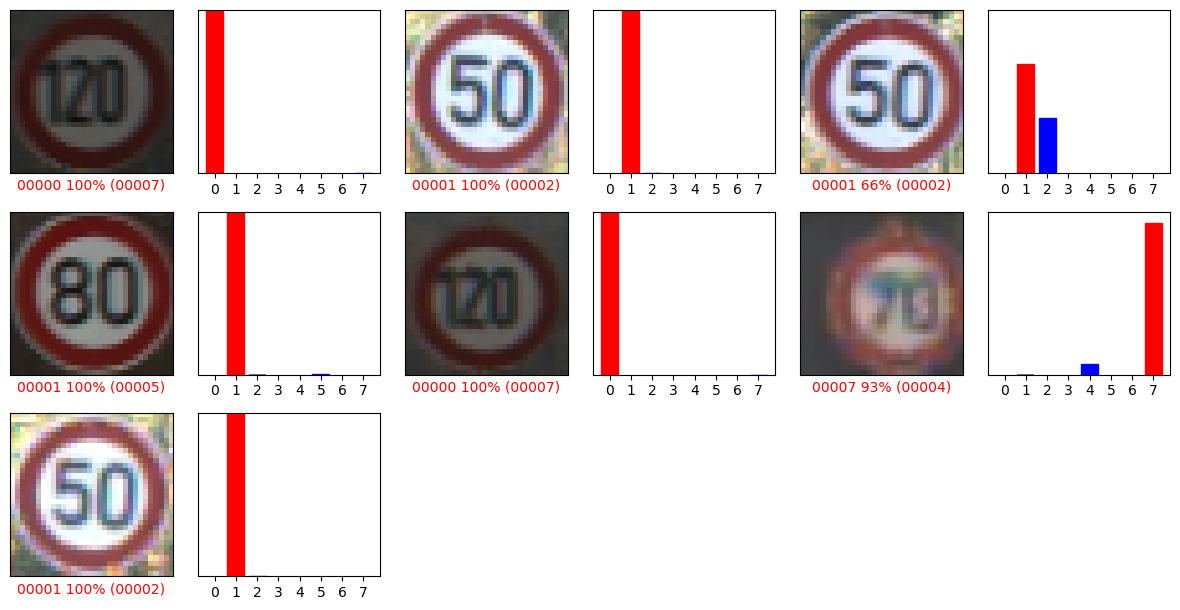

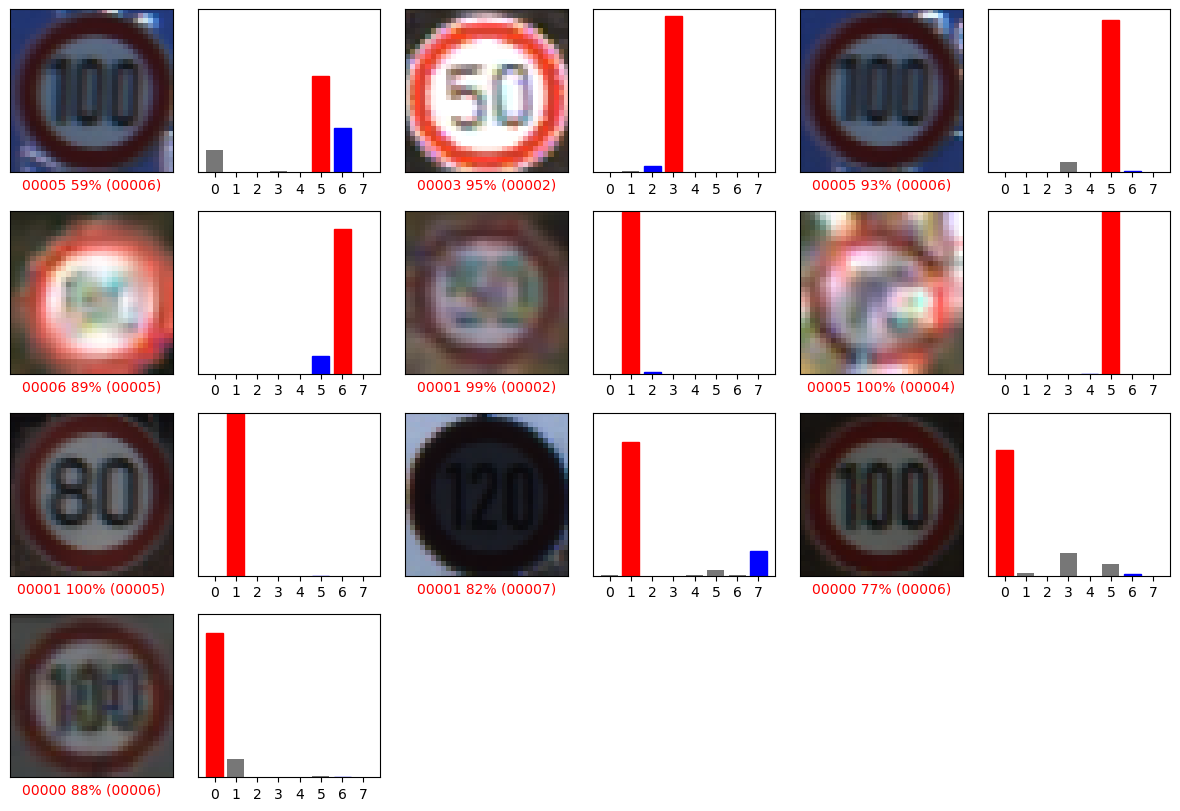

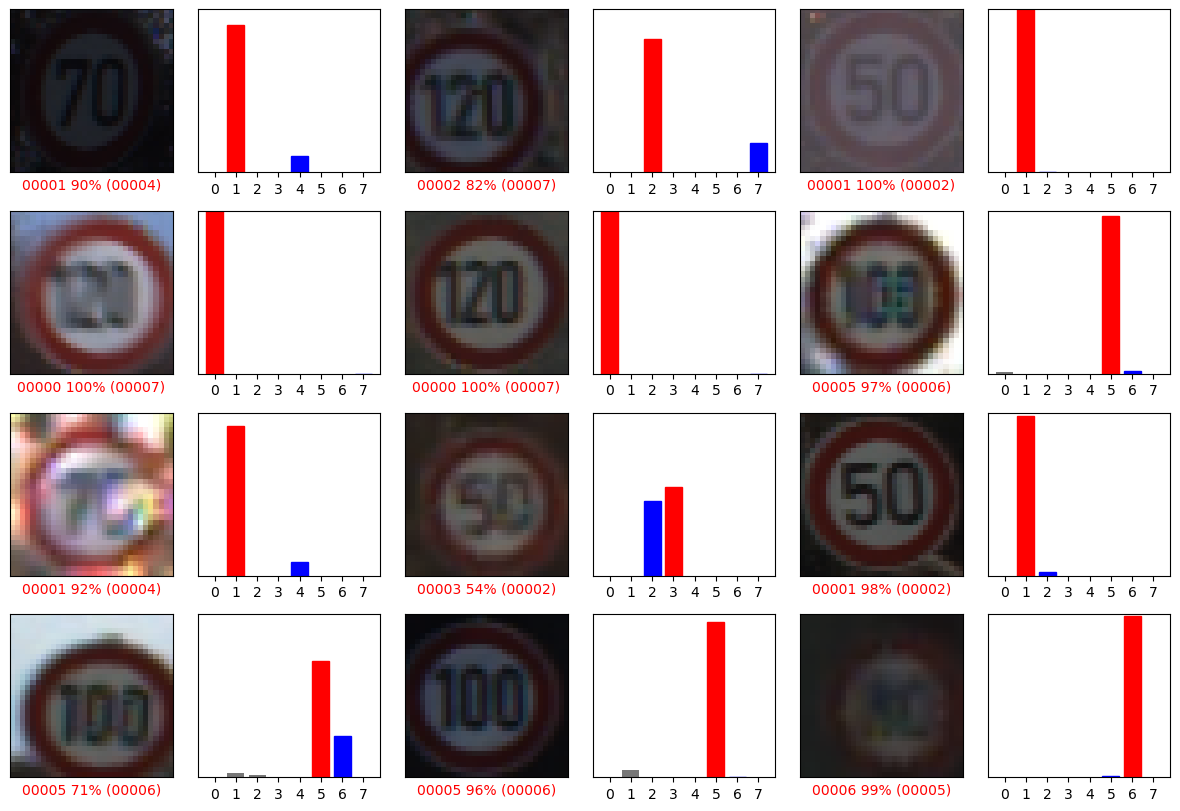

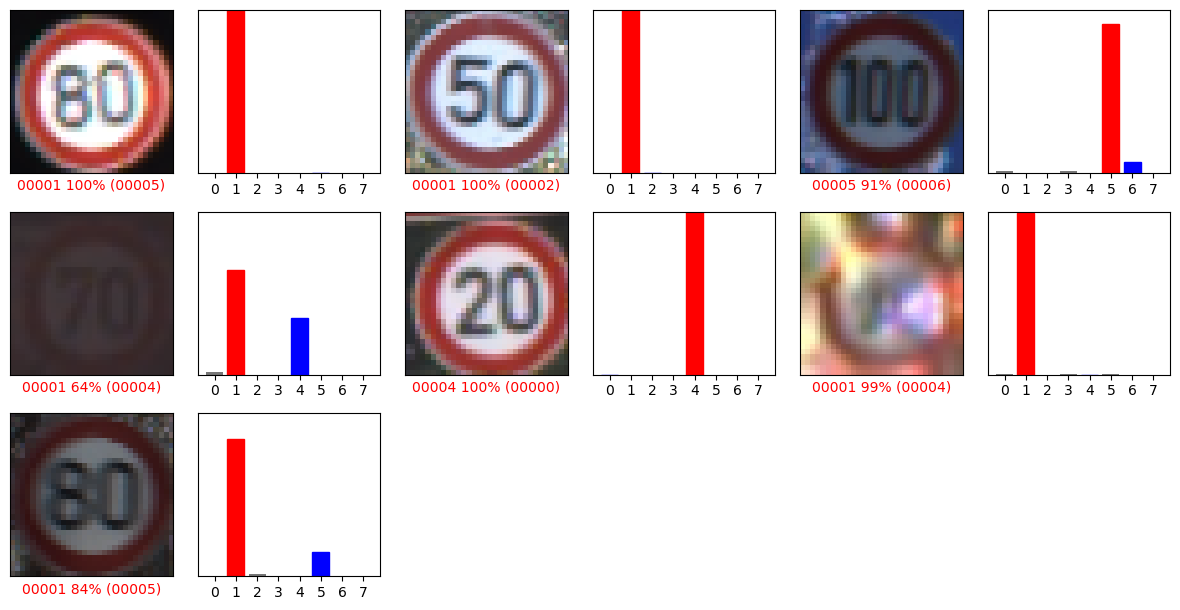

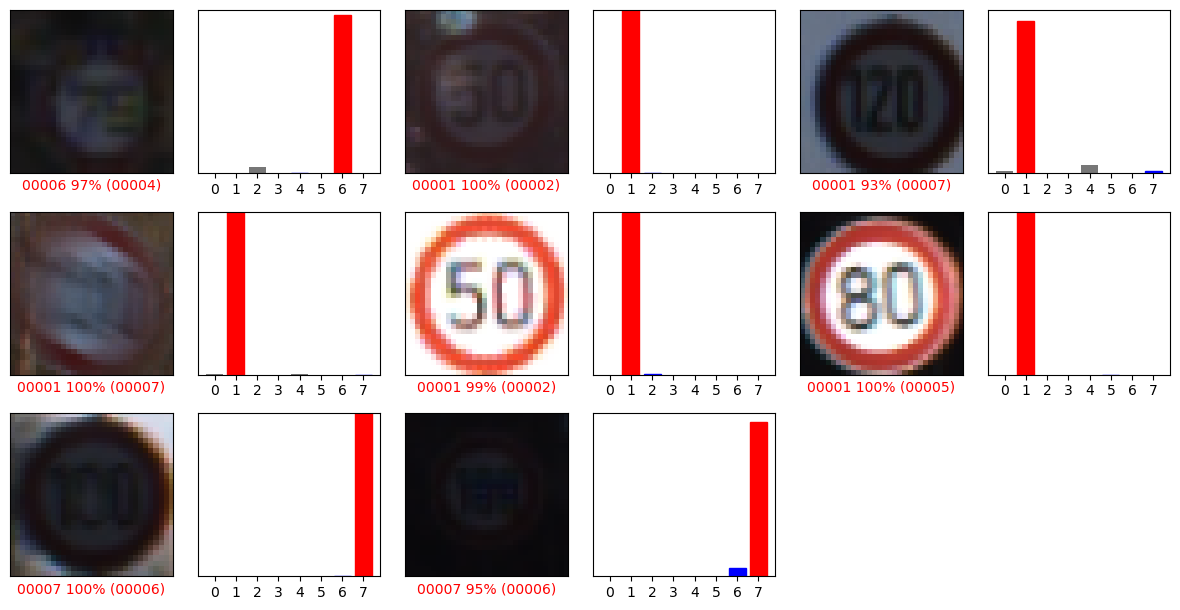

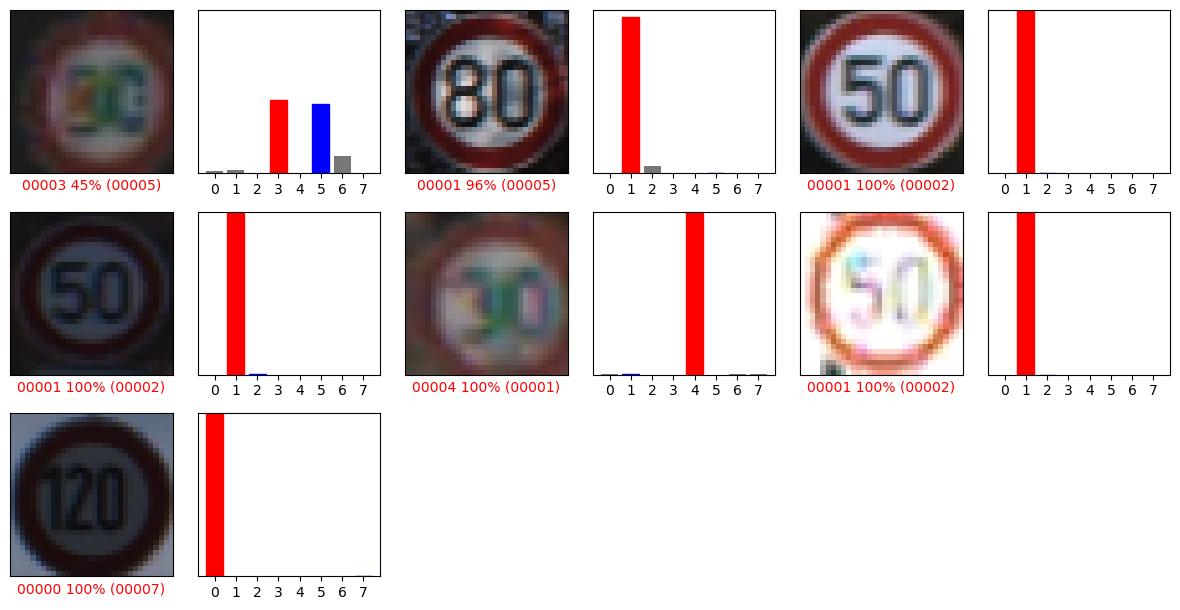

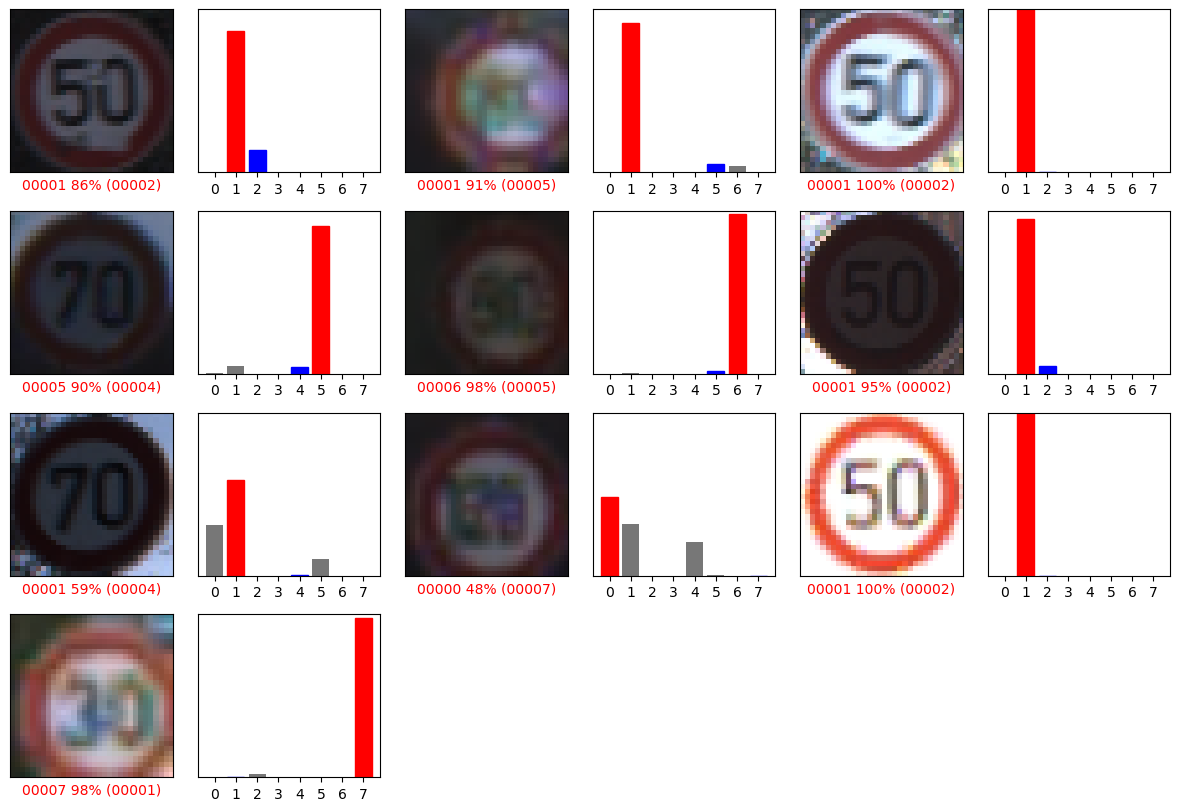

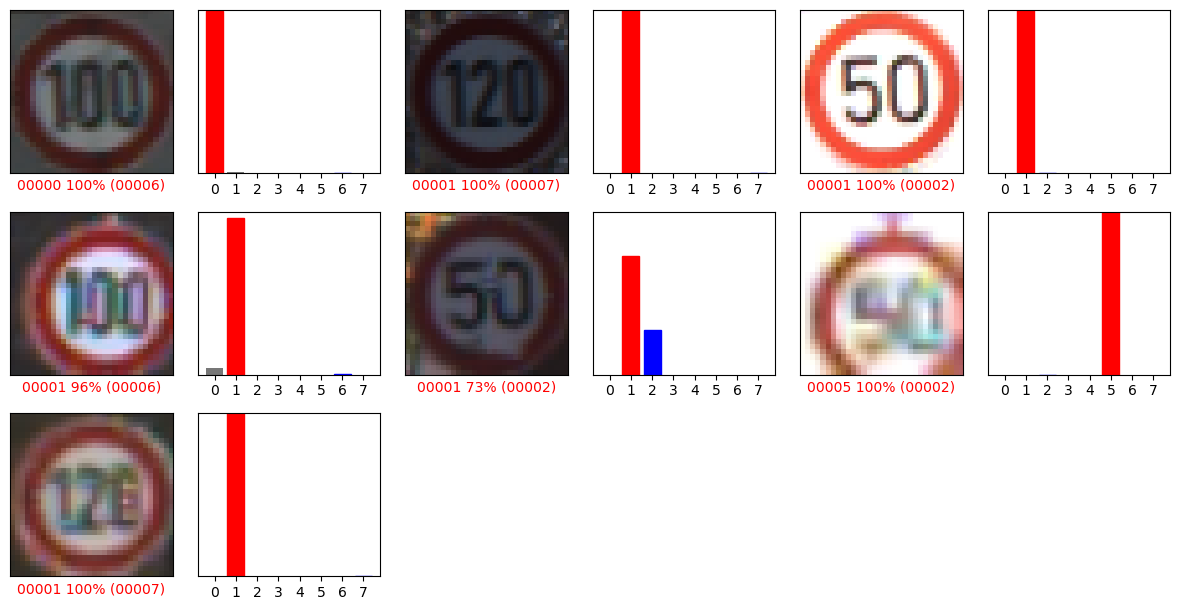

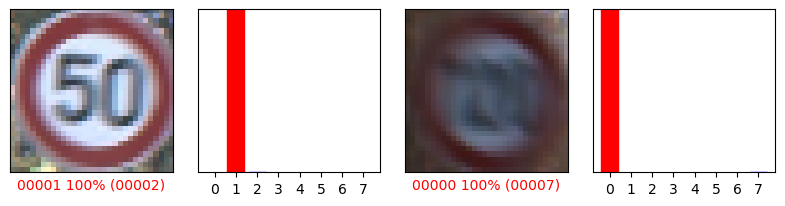

In [35]:
for images, labels in testset.take(10):  # take 10 batches of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
    preds = modelV2.predict(numpy_images)  
    show_misclassified(preds, numpy_labels, numpy_images, 5, 3)

## Confusion Matrix

The matrix columns represent the prediction labels and the rows represent the real labels.

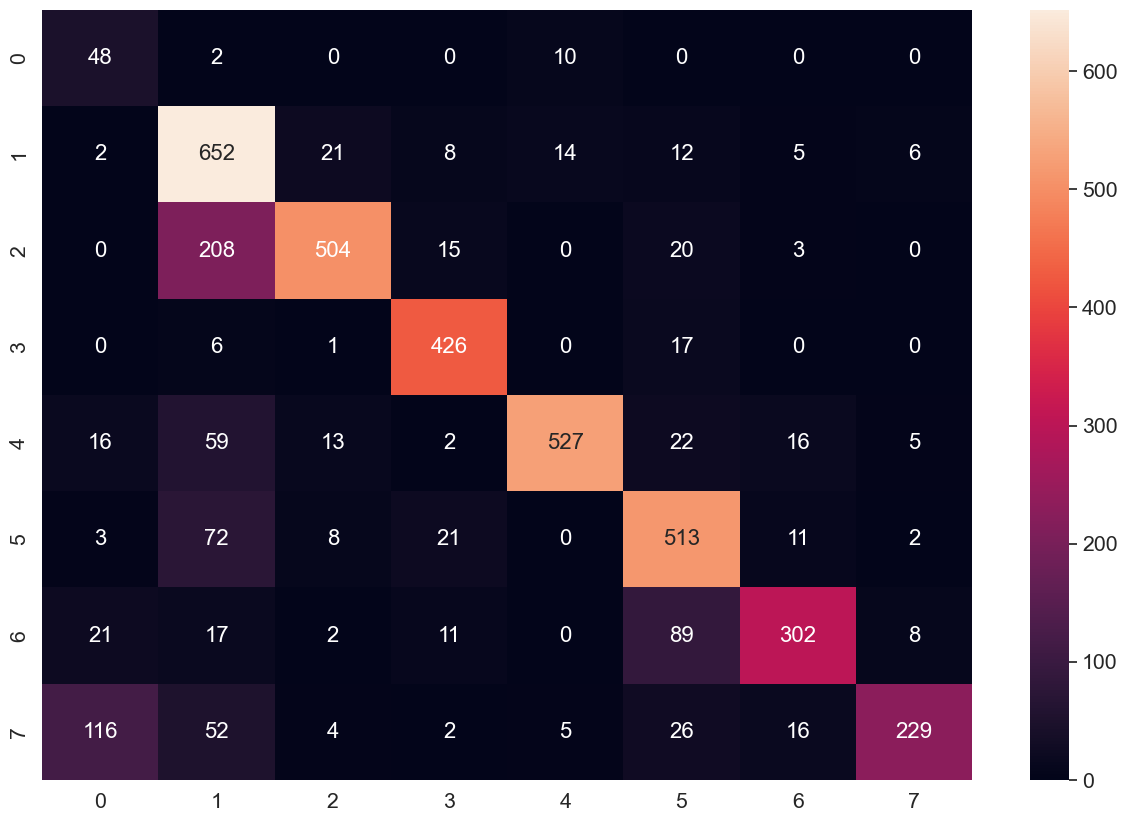

class:  0  total images:  60  % correct:  0.8
class:  1  total images:  720  % correct:  0.9055555555555556
class:  2  total images:  750  % correct:  0.672
class:  3  total images:  450  % correct:  0.9466666666666667
class:  4  total images:  660  % correct:  0.7984848484848485
class:  5  total images:  630  % correct:  0.8142857142857143
class:  6  total images:  450  % correct:  0.6711111111111111
class:  7  total images:  450  % correct:  0.5088888888888888


In [36]:
show_confusion_matrix(modelV2, testset)